# Natural Language Processing

## Package Setup

To perform some natural language processing tasks, it will be necessary to download some additional Python libraries. Using the Anaconda Terminal in admin mode, install the following packages:

* `conda install gensim` - The gensim package helps with processing text by building an index for a document collection. Comparison between documents will help determine similarity. 
* `conda install -c conda-forge wordcloud` - The wordcloud package allows for visualization of a resulting data analysis by showing more popular words in larger font.
   * Note: conda-forge is another location to get packages from. It is community driven (https://conda-forge.org/)

In [1]:
%pylab inline
import requests, re
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
pd.set_option('max_columns', 40)
pd.set_option('colwidth', 300)

Populating the interactive namespace from numpy and matplotlib


The nltk library comes with text collections (corpus/corpora), grammtical structures, models, etc. (http://www.nltk.org/nltk_data/). These are all available for download.

In [2]:
nltk.download('punkt') # Used for tokenizing strings
nltk.download('stopwords') # Common no-meaning words
nltk.download('wordnet') # Lexical database Used for finding word meanings, synonyms, antonyms, etc.

[nltk_data] Downloading package punkt to /Users/akshayd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akshayd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/akshayd/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## NBA Mock Draft Data

Each year, National Basketball Association (NBA) teams participate in an amateur draft, through which they can acquire the rights to sign new players to contracts for the upcoming season(s). Much effort is dedicated to evaluating the potential of the players, including a substantial amount of scouting, either during their play for previous organizations (e.g., National Collegiate Athletics Association, international professional leagues) or at the NBA draft combine where players are given an opportunity to showcase their potential. In addition to their statistical output, there are many characteristics of players that are best captured via scouting reports, which requires manual review or natural language processing to analyze.

In [3]:
# Import mock draft table
df = pd.read_csv('nba_draft_scouting_reports.csv')
df.head(2)

,#,Team,Player,H,W,P,School,C,url,Strengths,Weaknesses
0,1,Phoenix,DeAndre Ayton,7-0,260,C,Arizona,Fr.,http://www.nbadraft.net/players/deandre-ayton,Posesses can't miss talent with the chance to develop into a generational big ... Seven-footer with great coordination and fluidity ... Great size and length with a 7'5.5 wingspan and 9'3 standing reach ... Runs the floor well with great agility ... Good strength level as well as body frame. Ver...,"Ayton didn't make the strides one would hope in his senior year ... He did seem more focused towards the end of the season after losing his #1 player in class status nearly universally, but it appeared he got too comfortable sitting at the top spot for too long ... He rarely played like he had a..."
1,2,Memphis,Marvin Bagley,6-11,235,PF,Duke,Fr.,http://www.nbadraft.net/players/marvin-bagley,"NBA-ready body ... Positional versatility ... Displays unusually smooth and fluid movements for his 6'11"", 234-pound frame ... Elite and agile athlete ... Great lateral quickness ... Exceptional leaper (jumps well off both feet) ...Elevates quickly and really gets off the floor well for his seco...",Lacks the wingspan of other big men in his class ... Has to continue to fill out his frame with upper and lower body strength ... Sometimes gets out-muscled in the paint/post ... Lack of strength keeps him from controlling the paint on defense ... Ball handling is solid but still needs to get be...


## Natural Language Processing

As suggested by the name, the majority of the work in the NLP space involves text processing tasks. We have already developed several categories of techniques that also contribute to NLP:

* Scalar string methods (e.g., .split, .lower)
* Regular expressions (e.g., .search, .match, .sub, .split)
* Vectorized string methods in pandas (.str)

These methods form the foundation for NLP, but the nltk (Natural Language Toolkit) and gensim packages offer substantially more functionality. There is also some functionality in scikit-learn, you can explore these features at: http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction.

In [6]:
import string, itertools
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.cluster import KMeans

Let's select the scouting report (i.e., strengths or weaknesses) for a specific player:

In [7]:
# Select scouting report for review for an individual player
pid = 1
report = 'Strengths'
print(df[['Player','H','W','P','School','C']].loc[pid])
s = df.at[pid, report]
s

Player    Marvin Bagley
H                  6-11
W                   235
P                    PF
School             Duke
C                   Fr.
Name: 1, dtype: object


'NBA-ready body ... Positional versatility ... Displays unusually smooth and fluid movements for his 6\'11", 234-pound frame ... Elite and agile athlete ... Great lateral quickness ... Exceptional leaper (jumps well off both feet) ...Elevates quickly and really gets off the floor well for his second and third jumps ... Plays effortlessly above the rim ... Possesses great hands and quick feet... Catches everything that comes his way ... Very coordinated in his movements ... Has good body control ... Good overall ball-handler for a big man ... Multifaceted offensive skillset ... Versatile/natural scorer ... Polished footwork in the post ... Can shoulder his team\'s offensive load ... Gets to the rim easily ... Strong finisher around the basket with a soft touch ... Can score around the rim with either hand ... Solid low post scorer ... Possesses a bevy of floaters, runners, and hook shots ... Gets his defenders off balance with an array of ball fakes ... Does a good job of working around

### Text Standardization

The first set of NLP steps to consider involve standardizing the text for analysis. Some ideas to do this include:

* Converting to lower case
* Removing unnecessary punctuation
* Tokenization
* Removing stop words
* Stemming/Lemmatization

#### Converting to Lower Case

In [8]:
s = s.lower()
s

'nba-ready body ... positional versatility ... displays unusually smooth and fluid movements for his 6\'11", 234-pound frame ... elite and agile athlete ... great lateral quickness ... exceptional leaper (jumps well off both feet) ...elevates quickly and really gets off the floor well for his second and third jumps ... plays effortlessly above the rim ... possesses great hands and quick feet... catches everything that comes his way ... very coordinated in his movements ... has good body control ... good overall ball-handler for a big man ... multifaceted offensive skillset ... versatile/natural scorer ... polished footwork in the post ... can shoulder his team\'s offensive load ... gets to the rim easily ... strong finisher around the basket with a soft touch ... can score around the rim with either hand ... solid low post scorer ... possesses a bevy of floaters, runners, and hook shots ... gets his defenders off balance with an array of ball fakes ... does a good job of working around

#### Removing Unnecessary Punctuation

In [9]:
s = re.sub('[,()]', '', s)
s

'nba-ready body ... positional versatility ... displays unusually smooth and fluid movements for his 6\'11" 234-pound frame ... elite and agile athlete ... great lateral quickness ... exceptional leaper jumps well off both feet ...elevates quickly and really gets off the floor well for his second and third jumps ... plays effortlessly above the rim ... possesses great hands and quick feet... catches everything that comes his way ... very coordinated in his movements ... has good body control ... good overall ball-handler for a big man ... multifaceted offensive skillset ... versatile/natural scorer ... polished footwork in the post ... can shoulder his team\'s offensive load ... gets to the rim easily ... strong finisher around the basket with a soft touch ... can score around the rim with either hand ... solid low post scorer ... possesses a bevy of floaters runners and hook shots ... gets his defenders off balance with an array of ball fakes ... does a good job of working around the 

#### Tokenization

Tokenization is the process of converting a body of text (string) into a list of singular elements (tokens). The nltk package offers several methods for tokenization, the most commonly used are:

* Word tokenization (**word_tokenize**)
* Sentence tokenization (**sent_tokenize**)
* Regex tokenization (**regex_tokenize**)

The type of tokenization that you use depends on the granularity required for your analysis.

In [10]:
s

'nba-ready body ... positional versatility ... displays unusually smooth and fluid movements for his 6\'11" 234-pound frame ... elite and agile athlete ... great lateral quickness ... exceptional leaper jumps well off both feet ...elevates quickly and really gets off the floor well for his second and third jumps ... plays effortlessly above the rim ... possesses great hands and quick feet... catches everything that comes his way ... very coordinated in his movements ... has good body control ... good overall ball-handler for a big man ... multifaceted offensive skillset ... versatile/natural scorer ... polished footwork in the post ... can shoulder his team\'s offensive load ... gets to the rim easily ... strong finisher around the basket with a soft touch ... can score around the rim with either hand ... solid low post scorer ... possesses a bevy of floaters runners and hook shots ... gets his defenders off balance with an array of ball fakes ... does a good job of working around the 

In [11]:
# Word tokenization
print(word_tokenize(s))

['nba-ready', 'body', '...', 'positional', 'versatility', '...', 'displays', 'unusually', 'smooth', 'and', 'fluid', 'movements', 'for', 'his', "6'11", "''", '234-pound', 'frame', '...', 'elite', 'and', 'agile', 'athlete', '...', 'great', 'lateral', 'quickness', '...', 'exceptional', 'leaper', 'jumps', 'well', 'off', 'both', 'feet', '...', 'elevates', 'quickly', 'and', 'really', 'gets', 'off', 'the', 'floor', 'well', 'for', 'his', 'second', 'and', 'third', 'jumps', '...', 'plays', 'effortlessly', 'above', 'the', 'rim', '...', 'possesses', 'great', 'hands', 'and', 'quick', 'feet', '...', 'catches', 'everything', 'that', 'comes', 'his', 'way', '...', 'very', 'coordinated', 'in', 'his', 'movements', '...', 'has', 'good', 'body', 'control', '...', 'good', 'overall', 'ball-handler', 'for', 'a', 'big', 'man', '...', 'multifaceted', 'offensive', 'skillset', '...', 'versatile/natural', 'scorer', '...', 'polished', 'footwork', 'in', 'the', 'post', '...', 'can', 'shoulder', 'his', 'team', "'s", '

In [12]:
# Sentence tokenization - Not great because of the data that contains ellipses
sents = sent_tokenize(s)
print(len(sents), sents)

2 ['nba-ready body ... positional versatility ... displays unusually smooth and fluid movements for his 6\'11" 234-pound frame ... elite and agile athlete ... great lateral quickness ... exceptional leaper jumps well off both feet ...elevates quickly and really gets off the floor well for his second and third jumps ... plays effortlessly above the rim ... possesses great hands and quick feet... catches everything that comes his way ... very coordinated in his movements ... has good body control ... good overall ball-handler for a big man ... multifaceted offensive skillset ... versatile/natural scorer ... polished footwork in the post ... can shoulder his team\'s offensive load ... gets to the rim easily ... strong finisher around the basket with a soft touch ... can score around the rim with either hand ... solid low post scorer ... possesses a bevy of floaters runners and hook shots ... gets his defenders off balance with an array of ball fakes ... does a good job of working around t

In [13]:
# Regular expression tokenization - Method 1
words = regexp_tokenize(s, '[^. ]+') # This regex is the same as sent_tokenize
print(words)

['nba-ready', 'body', 'positional', 'versatility', 'displays', 'unusually', 'smooth', 'and', 'fluid', 'movements', 'for', 'his', '6\'11"', '234-pound', 'frame', 'elite', 'and', 'agile', 'athlete', 'great', 'lateral', 'quickness', 'exceptional', 'leaper', 'jumps', 'well', 'off', 'both', 'feet', 'elevates', 'quickly', 'and', 'really', 'gets', 'off', 'the', 'floor', 'well', 'for', 'his', 'second', 'and', 'third', 'jumps', 'plays', 'effortlessly', 'above', 'the', 'rim', 'possesses', 'great', 'hands', 'and', 'quick', 'feet', 'catches', 'everything', 'that', 'comes', 'his', 'way', 'very', 'coordinated', 'in', 'his', 'movements', 'has', 'good', 'body', 'control', 'good', 'overall', 'ball-handler', 'for', 'a', 'big', 'man', 'multifaceted', 'offensive', 'skillset', 'versatile/natural', 'scorer', 'polished', 'footwork', 'in', 'the', 'post', 'can', 'shoulder', 'his', "team's", 'offensive', 'load', 'gets', 'to', 'the', 'rim', 'easily', 'strong', 'finisher', 'around', 'the', 'basket', 'with', 'a', 

In [14]:
# Regex Tokenization - Method 2
re.split('\s*\.+\s*', s)[:-1] # Denote sentences as whitepsace followed by 1 or more periods, followed by whitespace. [:-1] = Remove the last sentence which is blank.

['nba-ready body',
 'positional versatility',
 'displays unusually smooth and fluid movements for his 6\'11" 234-pound frame',
 'elite and agile athlete',
 'great lateral quickness',
 'exceptional leaper jumps well off both feet',
 'elevates quickly and really gets off the floor well for his second and third jumps',
 'plays effortlessly above the rim',
 'possesses great hands and quick feet',
 'catches everything that comes his way',
 'very coordinated in his movements',
 'has good body control',
 'good overall ball-handler for a big man',
 'multifaceted offensive skillset',
 'versatile/natural scorer',
 'polished footwork in the post',
 "can shoulder his team's offensive load",
 'gets to the rim easily',
 'strong finisher around the basket with a soft touch',
 'can score around the rim with either hand',
 'solid low post scorer',
 'possesses a bevy of floaters runners and hook shots',
 'gets his defenders off balance with an array of ball fakes',
 'does a good job of working around th

Once we have processed our text into a list of words, we can begin to explore the data. The nltk package can be used to create a Text object, which facilitate searching a particular body of text.

In [15]:
obj = Text(words)
obj

<Text: nba-ready body positional versatility displays unusually smooth and...>

In [16]:
# Text length
len(obj)

476

In [17]:
# Concordance - Find text snippets that contain specified word
obj.concordance('great', width=100) # width = the width of the line showing the word in context

Displaying 6 of 6 matches:
 6'11" 234-pound frame elite and agile athlete great lateral quickness exceptional leaper jumps wel
mps plays effortlessly above the rim possesses great hands and quick feet catches everything that c
n traffic he keeps possessions alive and shows great timing cleaning up after missed shots can take
ation situations to force contested shots he's great at switching in pick-and-roll situations can s
n as a high character kid has the desire to be great motor is one of his strongest assets plays wit
otor is one of his strongest assets plays with great competitiveness and physicality out-works and 


In [18]:
# Specific word counts
obj.count('great')

6

#### Removing Stop Words

The next step involves removing stop words. Stop words are essentially words that lack significant meaning in the context of text analytics, but they are necessary for grammatical and contextual purposes. The nltk packages offers a corpus (body of text) of stop words that we can use to filter our text down to meaningful words, but we can always create our own list of stop words to filter.

In [19]:
# Preview stop words
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [20]:
# Filter stop words from tokenized words. Include filtration for "he's" which is unnecessary as the text is for men's basketball
words = [word for word in words if word not in stopwords.words('english') and word != "he's"]
print(words)

['nba-ready', 'body', 'positional', 'versatility', 'displays', 'unusually', 'smooth', 'fluid', 'movements', '6\'11"', '234-pound', 'frame', 'elite', 'agile', 'athlete', 'great', 'lateral', 'quickness', 'exceptional', 'leaper', 'jumps', 'well', 'feet', 'elevates', 'quickly', 'really', 'gets', 'floor', 'well', 'second', 'third', 'jumps', 'plays', 'effortlessly', 'rim', 'possesses', 'great', 'hands', 'quick', 'feet', 'catches', 'everything', 'comes', 'way', 'coordinated', 'movements', 'good', 'body', 'control', 'good', 'overall', 'ball-handler', 'big', 'man', 'multifaceted', 'offensive', 'skillset', 'versatile/natural', 'scorer', 'polished', 'footwork', 'post', 'shoulder', "team's", 'offensive', 'load', 'gets', 'rim', 'easily', 'strong', 'finisher', 'around', 'basket', 'soft', 'touch', 'score', 'around', 'rim', 'either', 'hand', 'solid', 'low', 'post', 'scorer', 'possesses', 'bevy', 'floaters', 'runners', 'hook', 'shots', 'gets', 'defenders', 'balance', 'array', 'ball', 'fakes', 'good', '

#### Stemming/Lemmatization

Now that we have our refined list of tokenized words, the next steps to consider including two approaches for accounting for the variability in word forms:

* **Stemming** is the process of truncating words to a common base form (stem), which may or may not be an actual word
* **Lemmatization** is also the process of converting words to a common base form, but the base form is a dictionary word and determined according to the lexical category (e.g., noun, adjective)

In [21]:
# Stemming
ps = PorterStemmer()
print([ps.stem(word) for word in words])

['nba-readi', 'bodi', 'posit', 'versatil', 'display', 'unusu', 'smooth', 'fluid', 'movement', '6\'11"', '234-pound', 'frame', 'elit', 'agil', 'athlet', 'great', 'later', 'quick', 'except', 'leaper', 'jump', 'well', 'feet', 'elev', 'quickli', 'realli', 'get', 'floor', 'well', 'second', 'third', 'jump', 'play', 'effortlessli', 'rim', 'possess', 'great', 'hand', 'quick', 'feet', 'catch', 'everyth', 'come', 'way', 'coordin', 'movement', 'good', 'bodi', 'control', 'good', 'overal', 'ball-handl', 'big', 'man', 'multifacet', 'offens', 'skillset', 'versatile/natur', 'scorer', 'polish', 'footwork', 'post', 'shoulder', "team'", 'offens', 'load', 'get', 'rim', 'easili', 'strong', 'finish', 'around', 'basket', 'soft', 'touch', 'score', 'around', 'rim', 'either', 'hand', 'solid', 'low', 'post', 'scorer', 'possess', 'bevi', 'floater', 'runner', 'hook', 'shot', 'get', 'defend', 'balanc', 'array', 'ball', 'fake', 'good', 'job', 'work', 'around', 'rim', 'get', 'open', 'shown', 'abil', 'expand', 'game',

In [22]:
# Lemmatizataion
lmtzr = WordNetLemmatizer()
words = [lmtzr.lemmatize(word) for word in words]
print(words)

['nba-ready', 'body', 'positional', 'versatility', 'display', 'unusually', 'smooth', 'fluid', 'movement', '6\'11"', '234-pound', 'frame', 'elite', 'agile', 'athlete', 'great', 'lateral', 'quickness', 'exceptional', 'leaper', 'jump', 'well', 'foot', 'elevates', 'quickly', 'really', 'get', 'floor', 'well', 'second', 'third', 'jump', 'play', 'effortlessly', 'rim', 'posse', 'great', 'hand', 'quick', 'foot', 'catch', 'everything', 'come', 'way', 'coordinated', 'movement', 'good', 'body', 'control', 'good', 'overall', 'ball-handler', 'big', 'man', 'multifaceted', 'offensive', 'skillset', 'versatile/natural', 'scorer', 'polished', 'footwork', 'post', 'shoulder', "team's", 'offensive', 'load', 'get', 'rim', 'easily', 'strong', 'finisher', 'around', 'basket', 'soft', 'touch', 'score', 'around', 'rim', 'either', 'hand', 'solid', 'low', 'post', 'scorer', 'posse', 'bevy', 'floater', 'runner', 'hook', 'shot', 'get', 'defender', 'balance', 'array', 'ball', 'fake', 'good', 'job', 'working', 'around',

#### Summary of Standardization

We have now reached a good place in regard to standardizing our word list. Let's define a function that performs all of the necessary tasks to standardize a scouting report (strengths or weaknesses) for a particular player.

In [39]:
def standardize_report(pid, report='Strengths'):
    # Print player information
    plyr = df.loc[pid]
    print(plyr['Player'], plyr['H'], plyr['W'], plyr['P'], plyr['School'], plyr['C'], '\n')
    
    # Extract report from player data frame
    s = df.at[pid, report]
    
    # Convert text to lower case
    s = s.lower()
    
    # Remove unnecessary punctuation
    s = re.sub('[,()]', '', s)
    
    # Regular expression tokenization - Method 1
    words = regexp_tokenize(s, '[^. ]+')
    
    # Filter stop words from tokenized words
    words = [word for word in words if word not in stopwords.words('english') and word != "he's"]
    
    # Lemmatizataion
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(word) for word in words]
    
    return words

##### Testing the Function

In [40]:
pid = 9
words = standardize_report(pid)
print(words)

Collin Sexton 6-2 185 PG Alabama Fr. 

['sexton', 'one', 'dynamic', 'guard', 'country', 'tool', 'become', 'versatile', 'weapon', 'nba', 'level', 'although', 'slightly', 'undersized', 'height', '6-2', 'play', 'great', 'physicality', 'athleticism', 'aggression', "6'6", '5', 'wingspan', "8'0", 'standing', 'reach', 'player', 'love', 'spotlight', 'seems', 'energized', 'bright', 'light', 'stiff', 'competition', 'love', 'play', 'contact', 'frame', 'absorb', 'going', 'rim', 'strength', 'athleticism', 'finish', 'contact', 'also', 'get', 'free', 'throw', 'line', 'high', 'rate', 'sexton', 'still', 'could', 'stand', 'become', 'consistent', 'charity', 'stripe', 'overall', 'convert', 'attempt', 'proficient', 'level', 'sexton', 'combine', 'strength', 'blazing', 'speed', 'agility', 'creative', 'ball', 'handling', 'form', 'lethal', 'slashing', 'arsenal', 'great', 'job', 'finding', 'angle', 'get', 'basket', 'changing', 'direction', 'keep', 'defender', 'balance', 'sexton', 'also', 'good', 'job', 'changin

### Text Analysis

Let's explore some basic techniques for analyzing the frequency of the words used in the scouting report. This is often referred to as a *bag-of-words* model. This helps to describe the occurrence 

##### Why Bag-Of-Words?

BOW is a very basic model and it is easy to use for NLP tasks such as text classification. Its strengths lie in its simplicity: it’s inexpensive to compute, and sometimes simpler is better when positioning or contextual info aren’t relevant.

In [41]:
# FreqDist
fd = FreqDist(Text(words)) # Using Text objects
fd.most_common(10)

[('sexton', 7),
 ('play', 5),
 ('get', 5),
 ('also', 4),
 ('guard', 3),
 ('nba', 3),
 ('level', 3),
 ('great', 3),
 ('ability', 3),
 ('become', 2)]

In [42]:
# Tabulate
fd.tabulate(10)

 sexton    play     get    also   guard     nba   level   great ability  become 
      7       5       5       4       3       3       3       3       3       2 


In [43]:
# Total samples and unique words
print('Total samples', fd.N())
print('Unique words', fd.B())

Total samples 224
Unique words 165


### Practice Problem

Review the file **candy_reasons.csv** which includes observations for why candy should be eaten and why candy should not be eaten.

Modify the `standardize_report` function for this data, using the `why_candy` column as the default. Call the new function `standardize_report2`. Then, check the most frequent words for response ID = 36.

In [29]:
candy_df=pd.read_csv('candy_reasons.csv')

In [32]:
candy_df.head()

,response_id,why_candy,why_not_candy
0,11,GOOD,HATE NOTHING
1,12,GOOD,BECAUSE IT MAKES ME SICK!!!!! >.<
2,13,BECAUSE EATING MM MAKES ME FEEL LIKE I AM SITTING ON A SOFA,BECAUSE ITS GREEN
3,14,"BECAUSE HERSHEY'S IS USUALLY JUST PURE CHOCOLATE, WITH NO OTHER TASTE.\nSADLY DIDN'T GET ONE NOW.",BECAUSE ITS POORLY COOKED
4,15,BECAUSE IT TASTES GOOD AND I FEEL SWEETNESS ;),BECAUSE IT'S YUCKKKKK


In [35]:
def standardize_report2(rid, report='why_candy'):
    # Print player information
    plyr = candy_df.loc[rid-11]
    print(plyr['response_id'], plyr['why_candy'], plyr['why_not_candy'], '\n')
    
    # Extract report from player data frame
    s = candy_df.at[rid-11, report]
    
    # Convert text to lower case
    s = s.lower()
    
    # Remove unnecessary punctuation
    s = re.sub('[,()]', '', s)
    
    # Regular expression tokenization - Method 1
    words = regexp_tokenize(s, '[^. ]+')
    
    # Filter stop words from tokenized words
    words = [word for word in words if word not in stopwords.words('english') and word != "he's"]
    
    # Lemmatizataion
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(word) for word in words]
    
    return words

In [36]:
rid=36
words=standardize_report2(rid)
print(words)

36 I HAVE A SWEET TOOTH. I LOVE ANYTHING SWEET (NOT TOO SWEET THOUGH). IT'S BITTER AF. I MEAN HOW CAN ANYBODY EVER LIKE IT! 

['sweet', 'tooth', 'love', 'anything', 'sweet', 'sweet', 'though']


## Text Data Visualization

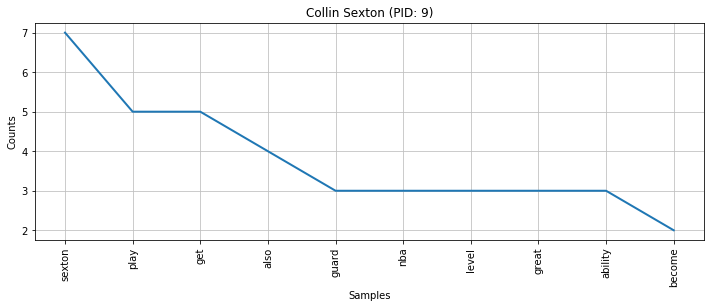

In [44]:
# Visualize frequency of most common words
plt.figure(figsize=(12,4))
fd.plot(10, title=df.loc[pid, 'Player'] + ' (PID: ' + str(pid) + ')')  # Frequency plot for top 10 words for a player (PID)

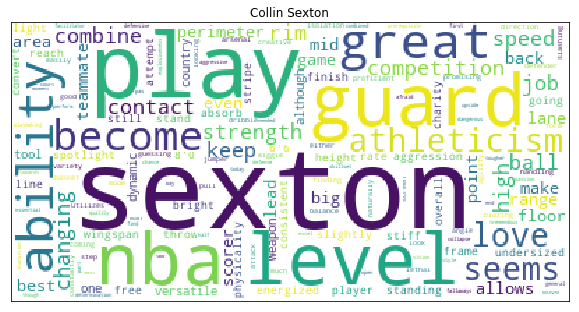

In [45]:
# Word Cloud
wc = WordCloud(background_color='white').generate(' '.join(words))
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.imshow(wc)
plt.title(df.loc[pid, 'Player']);

## Creating and Using a Corpus (Document Collection)

OK great, we can analyze a single report for a single player ... how can we analyze the scouting reports for multiple players? In order to do this, we need to assemble our scouting reports into a *corpus*, which is a collection of documents. In our case a "document" is a scouting report for a particular player, and the collection will cover the entire set of players.

In [46]:
df.loc[:, ['Player','Strengths']].head(5)

,Player,Strengths
0,DeAndre Ayton,Posesses can't miss talent with the chance to develop into a generational big ... Seven-footer with great coordination and fluidity ... Great size and length with a 7'5.5 wingspan and 9'3 standing reach ... Runs the floor well with great agility ... Good strength level as well as body frame. Ver...
1,Marvin Bagley,"NBA-ready body ... Positional versatility ... Displays unusually smooth and fluid movements for his 6'11"", 234-pound frame ... Elite and agile athlete ... Great lateral quickness ... Exceptional leaper (jumps well off both feet) ...Elevates quickly and really gets off the floor well for his seco..."
2,Jaren Jackson Jr.,"6'10 athletic big man with great length (7'4 wingspan and 9'1 standing reach) ... Good athleticism, energy, and activity ... Mobile, well-coordinated, and fluid ... Good hands and touch around the basket ... Can finish with either hand, doesn't hesitate to shoot with his left hand ... Good rebou..."
3,Luka Doncic,"What's most impressive about him is the maturity and the polish and completeness of his game at just 16 years of age, basically from all standpoints ... As a 6-7 SG, he already has a solid body, ready to compete at the senior level, with a wide frame, quite developed from a muscular standpoint, ..."
4,Michael Porter,"It's not often that you find an elite level size/shooter/athlete package at the high school level ... Extremely mature, focused and hard working individual ... Smooth and athletic wing forward with high level intangibles and competitiveness ... Possesses tremendous size for a wing forward at 6'1..."


In [47]:
# Process strength reports and assemble into corpus
reports = []
for pid in df.index:
    if type(df.at[pid, 'Strengths']) == str:
        reports.append(standardize_report(pid))
len(reports)

DeAndre Ayton 7-0 260 C Arizona Fr. 

Marvin Bagley 6-11 235 PF Duke Fr. 

Jaren Jackson Jr. 6-11 240 PF Michigan St. Fr. 

Luka Doncic 6-8 225 SG/SF Slovenia Intl. 

Michael Porter 6-10 215 SF Missouri Fr. 

Trae Young 6-2 180 PG Oklahoma Fr. 

Wendell Carter 6-10 260 PF/C Duke Fr. 

Mohamed Bamba 7-0 220 C Texas Fr. 

Mikal Bridges 6-7 210 SG/SF Villanova Jr. 

Collin Sexton 6-2 185 PG Alabama Fr. 

Kevin Knox 6-9 215 SF/PF Kentucky Fr. 

Miles Bridges 6-7 230 SF/PF Michigan St. So. 

Lonnie Walker 6-4 200 SG Miami Fr. 

Khyri Thomas 6-3 210 PG/SG Creighton Jr. 

Robert Williams 6-9 240 PF/C Texas A&M So. 

Zhaire Smith 6-5 195 SG Texas Tech Fr. 

Anfernee Simons 6-3 180 PG/SG Undecided HSSr. 

Gary Trent Jr. 6-6 215 SG Duke Fr. 

Troy Brown 6-7 215 PG/SG Oregon Fr. 

Dzanan Musa 6-9 195 SF Bosnia & Herz... Intl. 

Donte DiVincenzo 6-4 205 SG Villanova So. 

Trevon Duval 6-2 190 PG Duke Fr. 

Omari Spellman 6-9 260 PF/C Villanova Fr. 

Landry Shamet 6-4 190 PG/SG Wichita State So. 



33

In [48]:
# Define dictionary of scouting reports
D = Dictionary(reports) # from gensim.corpora.dictionary
print('Number of words:', D.num_pos)

# Create corpus
corpus = [D.doc2bow(report) for report in reports]
print('Number of documents in corpus:', len(corpus))

# For **doc2bow** method, it will convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples.
# Each word is assumed to be a tokenized and normalized string (either unicode or utf8-encoded).
# No further preprocessing is done on the words in document; apply tokenization, stemming etc. before calling this method.

Number of words: 5704
Number of documents in corpus: 33


In [49]:
# Preview bag-of-words for specific document
pid = 1
print('Number of words in document:', len(corpus[pid]))
corpus[pid][:10]   # First 10 token_ids and their associated count

Number of words in document: 220


[(7, 2),
 (10, 1),
 (13, 3),
 (14, 1),
 (20, 1),
 (21, 4),
 (22, 1),
 (23, 2),
 (26, 2),
 (36, 1)]

In [50]:
# Report top N words from specific document (using the token IDs)
N = 10
print('Player:', df.at[pid, 'Player'])
[(i, D.get(i), count) for i, count in sorted(corpus[pid], key=lambda token: token[1], reverse=True)[:N]] # key in sorted function allows a function to execute decide order

Player: Marvin Bagley


[(62, 'great', 6),
 (104, 'rim', 5),
 (115, 'shot', 5),
 (21, 'ball', 4),
 (60, 'get', 4),
 (133, 'well', 4),
 (232, 'offensive', 4),
 (13, 'around', 3),
 (52, 'foot', 3),
 (61, 'good', 3)]

In [51]:
# Determine total word counts across the entire corpus

all_word_counts = {}
for word_id, word_count in itertools.chain.from_iterable(corpus):
    if word_id in all_word_counts:
        all_word_counts[word_id] += word_count
    else:
        all_word_counts[word_id] = 1

# Create a sorted list from the dictionary: sorted_word_count
word_counts = sorted(all_word_counts.items(), key=lambda item: item[1], reverse=True) 

# Print the top 10 words across all documents alongside the count
for word_id, word_count in word_counts[:10]:
    print(D.get(word_id), word_count) # Remember: D represents the dictionary of scouting reports

good 105
shot 88
ball 69
well 64
great 63
get 58
game 55
play 55
ability 50
guard 44


In [52]:
# Assemble all words with frequencies for Word Cloud
all_words = []
for word_id, word_count in word_counts:
    all_words.extend([D.get(word_id)] * word_count) # extend the list by a word a specific number of times (word_count)
print(len(all_words), all_words[:150])

5510 ['good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good', 'shot', 'shot', 'shot', 'shot', 'shot', 'shot', 'shot', 'shot', 'shot', 'shot', 'shot', 'shot', 'shot', 'shot', 'shot', 'shot', 'shot', 'shot', 'shot', 's

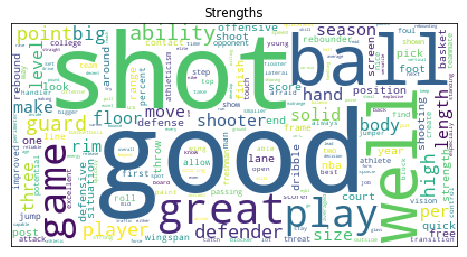

In [53]:
# Word Cloud
wc = WordCloud(background_color='white', collocations=False).generate(' '.join(all_words))
plt.figure(figsize=(8,8))
plt.xticks([])
plt.yticks([])
plt.imshow(wc)
plt.title('Strengths');

## Term Frequency and Inverse Document Frequency

We have worked through some examples based on simple frequency counts of (meaningful) words. Let's extend to a more robust model, the term frequency-inverse document frequency (tf-idf) model, which captures the notion that some tokens are used more frequently in general, but may not convey much meaning about a particular document (player). Instead, we want to understand which tokens are used relatively more frequently within a document (player) than across the entire corpus.

Each word in a document is characterized by a weight that captures both the term frequency and the inverse document frequency:

$\text{tfidf}(t, d, D) = \text{tf}(t, d) * \text{idf}(t, D)$

where t is the token, d is the document, and D is the corpus. There are many forms of the *tf* and *idf* functions (see https://rare-technologies.com/pivoted-document-length-normalisation/ for more information). For now, a common approach for each term is as follows:

* $\text{tf}(t, d) = f_{t,d}$, where $f_{t,d}$ is the frequency of token t in document d 

* $\text{idf}(t, D) = -log \frac{N_t}{N}$, where $N_t$ is the number of documents where token t appears and N is the total number of documents

Therefore, a high tf-idf weight means that there is high term frequency within a given document and relatively low term frequency across the corpus.

In [54]:
# Create a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(corpus) # from gensim.models.tfidfmodel and now using the corpus (Document Collection) 
print('Number of tokens:', len(tfidf.dfs))

Number of tokens: 1464


In [55]:
# Get the tfidf weights of specific document: tfidf_weights from the model
pid = 1
tfidf_weights = tfidf[corpus[pid]]

# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, key=lambda word: word[1], reverse=True)

# Print the top 10 weighted words for selected player
print('Player:', df.at[pid, 'Player'])
for term_id, weight in sorted_tfidf_weights[:10]:
    print(term_id, D.get(term_id), weight)

# Print the weight for term ID 7 (for comparison below)
print('************')
[print(k, D.get(k), v) for k,v in sorted_tfidf_weights if k == 7];

Player: Marvin Bagley
159 coast 0.15342237967427913
226 movement 0.15342237967427913
283 take 0.11632983885624512
241 pick-and-roll 0.11548780278922127
295 using 0.11548780278922127
182 elite 0.10327559672225643
136 234-pound 0.0956784782796685
138 4/5 0.0956784782796685
141 agile 0.0956784782796685
145 asset 0.0956784782796685
************
7 ability 0.013047764677934028


Now, let's calculate the tfidf weights for each player, and create a DataFrame of tfidf weights for each player.

In [56]:
# Initialize empty DataFrame with rows for each token
wdf = pd.DataFrame(index=range(len(tfidf.dfs)))
wdf.head()

""
0
1
2
3
4


In [57]:
# Loop through documents in corpus to create weighted data frame
i = 0
for pid in df.index:
    if type(df.at[pid, 'Strengths']) == str:
        wdf[df.at[pid, 'Player']] = pd.Series(dict(tfidf[corpus[i]]))
        i += 1
wdf.fillna(0, inplace=True)

In [58]:
# Preview results
wdf.head(10)

# Note: ID 7 (ability) matches to the weighted word - 0.013048

,DeAndre Ayton,Marvin Bagley,Jaren Jackson Jr.,Luka Doncic,Michael Porter,Trae Young,Wendell Carter,Mohamed Bamba,Mikal Bridges,Collin Sexton,Kevin Knox,Miles Bridges,Lonnie Walker,Khyri Thomas,Robert Williams,Zhaire Smith,Anfernee Simons,Gary Trent Jr.,Troy Brown,Dzanan Musa,Donte DiVincenzo,Trevon Duval,Omari Spellman,Landry Shamet,Grayson Allen,Brandon McCoy,Elie Okobo,Tony Carr,Sviatoslav Mykhailiuk,Hamidou Diallo,Malik Newman,Goga Bitadze,Rawle Alkins
0,0.102127,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.065730,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.087356,0.000000,0.000000,0.0000,0.087346,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.056223,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.043495,0.000000,0.000000,0.0000,0.000000,0.000000,0.046271,0.0,0.036753,0.029160,0.000000,0.000000,0.0,0.039549,0.000000,0.000000,0.083982,0.000000,0.000000,0.000000,0.000000,0.0,0.042201,0.063962,0.000000,0.168335,0.000000,0.000000,0.000000,0.000000,0.060375,0.000000,0.000000
3,0.127378,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.127378,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.127378,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.127378,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.008685,0.013048,0.024554,0.0291,0.034738,0.017274,0.009240,0.0,0.007339,0.017469,0.000000,0.023814,0.0,0.000000,0.009552,0.019439,0.005590,0.010186,0.008998,0.009689,0.016239,0.0,0.008427,0.025545,0.008527,0.000000,0.039395,0.000000,0.008974,0.017196,0.012056,0.018477,0.007977
8,0.127378,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.043495,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.029160,0.047938,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.051012,0.000000,0.048522,0.000000,0.0,0.000000,0.000000,0.000000,0.056112,0.039457,0.027896,0.000000,0.043057,0.000000,0.092528,0.000000


Now that we have report-based features for each player's strengths, let's perform clustering in order to determine whether there are similar groups of players.

Clustering is useful for grouping data for a wide array of business reasons such as:
* Behavioral segmentation
   * Segment by purchase history
   * Define personas based on interests
   * Create profiles for activity monitoring
* Inventory categorization
   * Grouping inventory by sales metrics
   * Grouping inventory by production metrics
* Detecting bots or anomalies
   * Separate valid activity from bots
   * Detecting outliers by determining valid groups

In [59]:
# Define and fit KMeans cluster object. A cluster is simply a group of data. Domain knowledge will help determine number of clusters
k = 5  # Represents number of clusters to form/number of centroids to generate
cluster = KMeans(n_clusters=k) #from sklearn.cluster

# Compute the k-means clustering using the weights
cluster.fit(wdf.T);

In [60]:
# Determine cluster sizes in which to cluster the players
cid = cluster.predict(wdf.T)
pd.Series(cid).value_counts().sort_index()

0    5
1    5
2    7
3    7
4    9
dtype: int64

In [61]:
# Merge cluster membership with player data frame
pd.merge(df, pd.DataFrame(cid, index=wdf.columns, columns=['Cluster']), left_on='Player', right_index=True).drop(labels=['url','Strengths','Weaknesses'], axis=1).sort_values(by='Cluster')

,#,Team,Player,H,W,P,School,C,Cluster
20,21,Utah,Troy Brown,6-7,215,PG/SG,Oregon,Fr.,0
22,23,Indiana,Donte DiVincenzo,6-4,205,SG,Villanova,So.,0
26,27,Boston,Landry Shamet,6-4,190,PG/SG,Wichita State,So.,0
32,33,Atlanta,Tony Carr,6-5,200,PG,Penn State,So.,0
5,6,Chicago,Trae Young,6-2,180,PG,Oklahoma,Fr.,0
6,7,Sacramento,Wendell Carter,6-10,260,PF/C,Duke,Fr.,1
0,1,Phoenix,DeAndre Ayton,7-0,260,C,Arizona,Fr.,1
2,3,Dallas,Jaren Jackson Jr.,6-11,240,PF,Michigan St.,Fr.,1
4,5,Orlando,Michael Porter,6-10,215,SF,Missouri,Fr.,1
29,30,Atlanta,Brandon McCoy,7-0,255,C,UNLV,Fr.,1


In [62]:
# Assemble cluster centers into dataframe
ccdf = pd.DataFrame(cluster.cluster_centers_)
ccdf.columns = [D.get(i) for i in ccdf.columns]
ccdf

,1%,2%,5,60,7'5,82,9'3,ability,accurate,afraid,agility,alters,another,around,athlete,attention,attracts,avoid,awareness,away,...,alkins',almost,among,arizona,assume,boy,carve,category,contain,continue,enticing,filled,future,improving,loose,maintaining,out-compete,roster,showcase,up-tempo
0,0.000000,0.000000e+00,0.012792,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.013611,0.000000e+00,5.579212e-03,0.015929,0.000000e+00,0.000000e+00,0.004142,2.018855e-02,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.014373,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.020425,3.494043e-02,0.051620,2.547567e-02,2.547567e-02,2.547567e-02,2.547567e-02,0.015443,2.547567e-02,1.992126e-02,0.015375,2.547567e-02,4.677563e-02,0.028371,2.233021e-02,4.215443e-02,2.547567e-02,0.020425,5.156651e-02,0.047107,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000,-8.673617e-19,0.000000,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,0.012152,-4.336809e-19,3.263501e-02,0.000000,-4.336809e-19,0.000000e+00,0.008966,1.997236e-02,8.673617e-19,-4.336809e-19,0.013235,-1.734723e-18,0.016665,...,-4.336809e-19,-4.336809e-19,-4.336809e-19,-8.673617e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19
3,0.009390,8.031908e-03,0.037551,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,0.008930,-4.336809e-19,-1.734723e-18,0.000000,-4.336809e-19,0.000000e+00,0.014245,-1.734723e-18,8.673617e-19,-4.336809e-19,0.000000,-1.734723e-18,0.000000,...,-4.336809e-19,-4.336809e-19,-4.336809e-19,-8.673617e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19,-4.336809e-19
4,0.000000,0.000000e+00,0.003240,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.013187,0.000000e+00,1.369213e-02,0.012143,0.000000e+00,-8.673617e-19,0.027812,6.565124e-03,8.673617e-19,0.000000e+00,0.000000,9.558756e-03,0.000000,...,1.299822e-02,1.299822e-02,1.299822e-02,2.599644e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02,1.299822e-02


In [63]:
# Report top N words for each cluster
N = 10
for i in ccdf.index:
    print('Cluster', i, '\n')
    sorted_weights = ccdf.loc[i].sort_values(ascending=False)
    print(sorted_weights.head(N), '\n')

Cluster 0 

carr          0.130714
percent       0.112632
young         0.107665
shamet        0.093659
guard         0.073928
season        0.070393
assist        0.057037
basketball    0.053980
also          0.053039
point         0.050063
Name: 0, dtype: float64 

Cluster 1 

nike        0.118506
eybl        0.118506
reliable    0.083315
ground      0.068825
within      0.066938
shoot       0.066186
man         0.064726
run         0.060486
reach       0.059546
stroke      0.056942
Name: 1, dtype: float64 

Cluster 2 

n'           0.058067
result       0.057681
create       0.055968
opponent     0.055076
help         0.053319
roll         0.052761
catch        0.045573
room         0.044726
others       0.044278
situation    0.044241
Name: 2, dtype: float64 

Cluster 3 

3              0.080314
association    0.070271
armour         0.070271
4              0.053146
number         0.052029
newman         0.050518
per            0.050407
bamba          0.049471
100            0.04684